In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import plotly.express as px

import acquire
import acq
import wrangle_zillow
import explore_zillow
import env

logerror: log(Zestimate) - log(Saleprice)

In [23]:
df0 = wrangle_zillow.get_zillow_single_unit_2017_cluster()
df0.shape

/Users/geary.shenck/codeup-data-science/clustering-exercises/wrangle_zillow.py:16: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("zillow_single_fam_sold_2017_cluster.csv", index_col = 0)


(77574, 68)

In [24]:
df0.logerror.describe()

count    77574.000000
mean         0.016805
std          0.170742
min         -4.655420
25%         -0.024310
50%          0.006673
75%          0.039292
max          5.262999
Name: logerror, dtype: float64

In [25]:
cols_missing, rows_missing = wrangle_zillow.summarize(df0)


DataFrame head: 

        id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  1727539  14297519                    NaN                       NaN   
1  1387261  17052889                    NaN                       NaN   
2    11677  14186244                    NaN                       NaN   
3  2288172  12177905                    NaN                       NaN   
4  1970746  10887214                    1.0                       NaN   

   basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0           NaN          3.5         4.0                  NaN   
1           NaN          1.0         2.0                  NaN   
2           NaN          2.0         3.0                  NaN   
3           NaN          3.0         4.0                  NaN   
4           NaN          3.0         3.0                  NaN   

   buildingqualitytypeid  calculatedbathnbr  ...  censustractandblock  \
0                    NaN                3.5  ...         6.059063e+13   
1     

In [26]:
cols_missing[cols_missing.percent_rows_missing > 75]

,num_rows_missing,percent_rows_missing
architecturalstyletypeid,77368,99.734447
basementsqft,77524,99.935545
buildingclasstypeid,77559,99.980664
decktypeid,76960,99.208498
finishedfloor1squarefeet,71539,92.220332
finishedsquarefeet13,77532,99.945858
finishedsquarefeet15,74547,96.097919
finishedsquarefeet50,71539,92.220332
finishedsquarefeet6,77188,99.502411
fireplacecnt,69287,89.317297


In [27]:
rows_missing[rows_missing.percent_cols_missing > 50]

,num_cols_missing,percent_cols_missing,count
12,35,51.470588,5163
13,36,52.941176,5793
14,37,54.411765,3630
15,38,55.882353,1932
16,39,57.352941,285
17,40,58.823529,230
18,41,60.294118,29
19,42,61.764706,26
20,43,63.235294,29
21,44,64.705882,79


In [28]:
df0.logerror.describe()

count    77574.000000
mean         0.016805
std          0.170742
min         -4.655420
25%         -0.024310
50%          0.006673
75%          0.039292
max          5.262999
Name: logerror, dtype: float64

In [29]:
df = df0.copy()

target = "logerror"

df = df.drop_duplicates(subset='id', keep="first")

df = df.drop(columns=[  "roomcnt","heatingorsystemtypeid","unitcnt","airconditioningtypeid","regionidcity",\
                        "finishedsquarefeet12","fullbathcnt","regionidneighborhood","regionidcounty",\
                        "propertylandusetypeid","propertycountylandusecode","propertyzoningdesc","assessmentyear",\
                        "buildingqualitytypeid","calculatedbathnbr","propertyzoningdesc","transactiondate"])

df.fips = np.where(df.fips == 6059,"Orange Cnty", 
                    np.where(df.fips == 6111,"Ventura Cnty", "Los Angeles Cnty"))

df.heatingorsystemdesc.fillna("None", inplace=True)
df.airconditioningdesc.fillna("None", inplace=True)
df.basementsqft.fillna(0,inplace=True)
df.garagecarcnt.fillna(0,inplace=True)
df.garagetotalsqft.fillna(0,inplace=True)
df['state'] = df['censustractandblock'].astype(str).str[0:1]
df['county'] = df['censustractandblock'].astype(str).str[1:4]
df['tract'] = df['censustractandblock'].astype(str).str[4:10]
df['block'] = df['censustractandblock'].astype(str).str[10:14]
df["logerror_bin"] = pd.cut(df.logerror,[-6, df.logerror.mean() - df.logerror.std(), df.logerror.mean() + df.logerror.std(), 10],labels=["<-1sig","-1sig~1sig",">1sig"])

cols_missing, rows_missing = wrangle_zillow.summarize(df)

df.drop(columns = cols_missing[cols_missing.percent_rows_missing > 75].index.tolist(),inplace=True)

discrete_list = ["id","fips","parcelid","garagecarcnt","latitude","bathroomcnt","logerror_bin",\
                "airconditioningdesc","heatingorsystemdesc","longitude","rawcensustractandblock",\
                "bedroomcnt","regionidzip","yearbuilt","censustractandblock","propertylandusedesc",\
                "state","county","tract","block"]
df[discrete_list] = df[discrete_list].astype("object")

continous_list = df.drop(columns=discrete_list).columns.tolist()

df = df.dropna()
df["error"] = 10**df.logerror

cols_missing, rows_missing = wrangle_zillow.summarize(df)

print(df.shape)

df.head().T

DataFrame head: 

        id  parcelid  architecturalstyletypeid  basementsqft  bathroomcnt  \
0  1727539  14297519                       NaN           0.0          3.5   
1  1387261  17052889                       NaN           0.0          1.0   
2    11677  14186244                       NaN           0.0          2.0   
3  2288172  12177905                       NaN           0.0          3.0   
4  1970746  10887214                       NaN           0.0          3.0   

   bedroomcnt  buildingclasstypeid  decktypeid  finishedfloor1squarefeet  \
0         4.0                  NaN         NaN                       NaN   
1         2.0                  NaN         NaN                    1465.0   
2         3.0                  NaN         NaN                       NaN   
3         4.0                  NaN         NaN                       NaN   
4         3.0                  NaN         NaN                       NaN   

   calculatedfinishedsquarefeet  ...  buildingclassdesc  heati

,0,1,2,3,4
id,1727539,1387261,11677,2288172,1970746
parcelid,14297519,17052889,14186244,12177905,10887214
basementsqft,0.0,0.0,0.0,0.0,0.0
bathroomcnt,3.5,1.0,2.0,3.0,3.0
bedroomcnt,4.0,2.0,3.0,4.0,3.0
calculatedfinishedsquarefeet,3100.0,1465.0,1243.0,2376.0,1312.0
fips,Orange Cnty,Ventura Cnty,Orange Cnty,Los Angeles Cnty,Los Angeles Cnty
garagecarcnt,2.0,1.0,2.0,0.0,0.0
garagetotalsqft,633.0,0.0,440.0,0.0,0.0
latitude,33634931.0,34449266.0,33886168.0,34245180.0,34185120.0


In [30]:
cols_missing

,num_rows_missing,percent_rows_missing
id,0,0.0
parcelid,0,0.0
basementsqft,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
garagecarcnt,0,0.0
garagetotalsqft,0,0.0
latitude,0,0.0


In [31]:
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = wrangle_zillow.split_tvt_continuous(df,target)

train -> (41286, 30)
validate -> (13762, 30)
test -> (13763, 30)


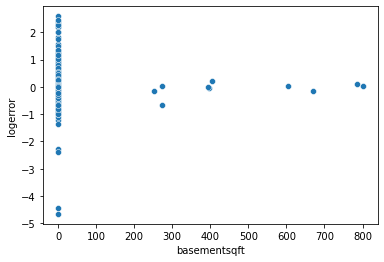

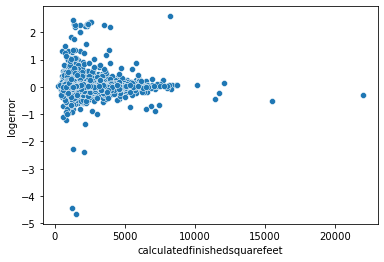

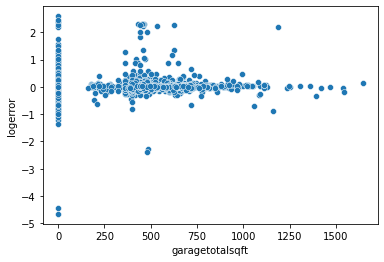

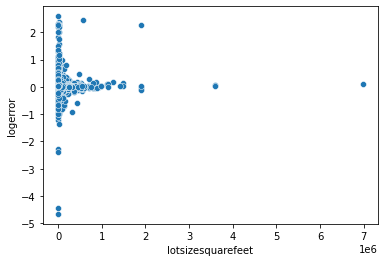

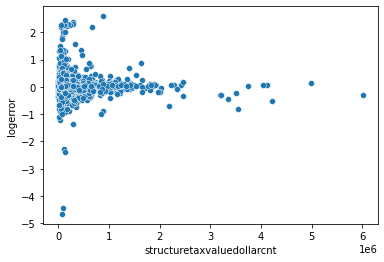

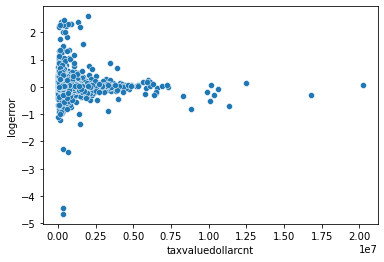

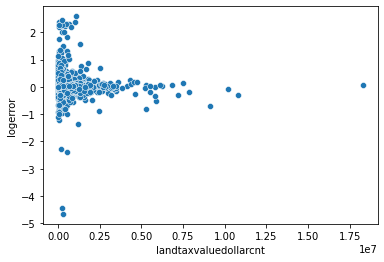

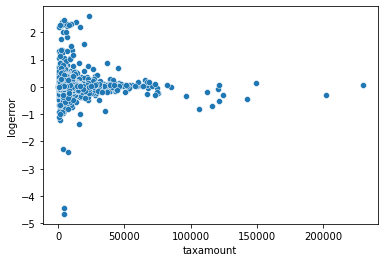

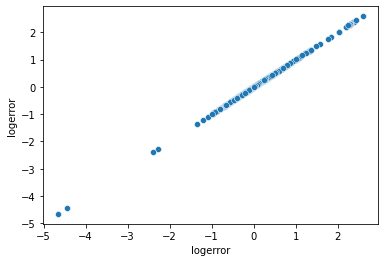

In [32]:
for col in continous_list:
    fig = sns.scatterplot(   data=train.sample(n=10000,random_state=123),
                        x=col,
                        y=target)
    plt.show()

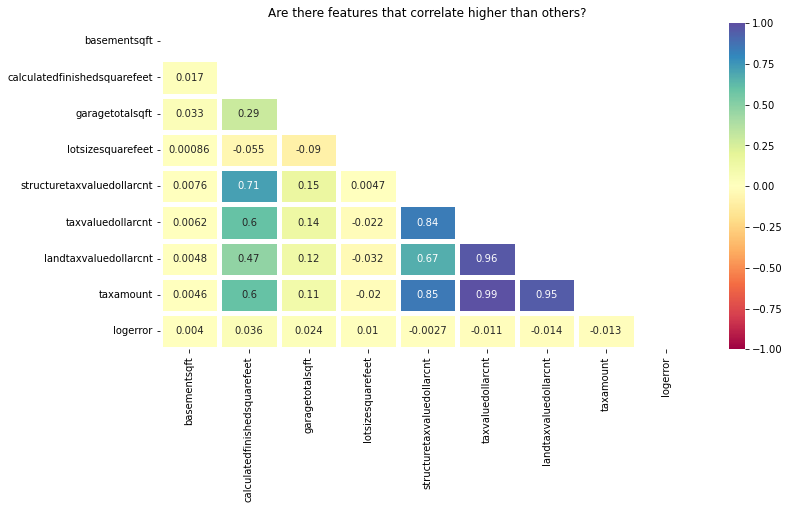

In [33]:
plt.figure(figsize=(12, 6))
kwargs = {'alpha':1,
            'linewidth':5, 
            'linestyle':'--',
            'linecolor':'white'}

sns.heatmap(train[continous_list].corr(),
            #map="YlGnBu", 
            cmap="Spectral",
            mask=(np.triu(np.ones_like(train[continous_list].corr(),dtype=bool))),
            annot=True,
            vmin=-1, 
            vmax=1, 
            #annot=True,
            **kwargs
            )
plt.title("Are there features that correlate higher than others?")
plt.show()

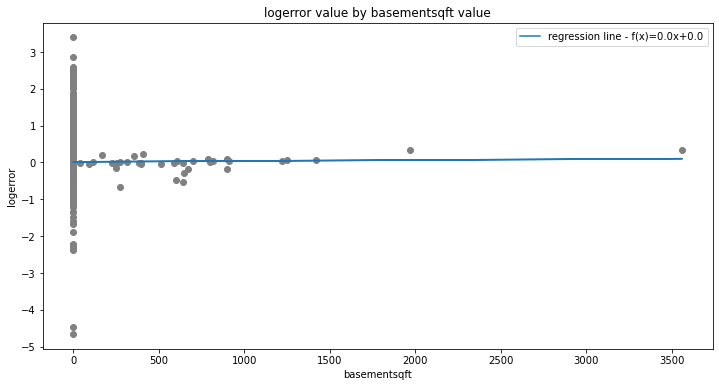

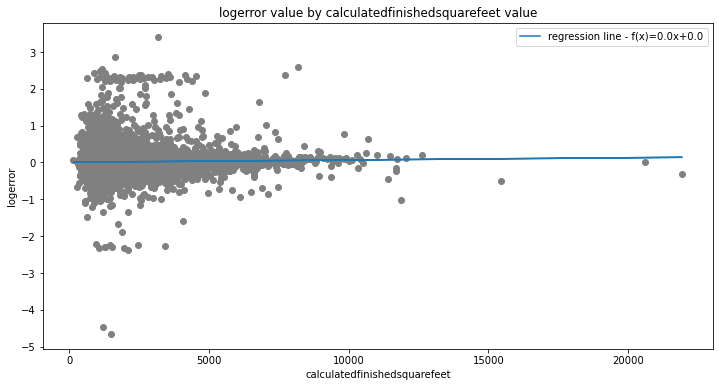

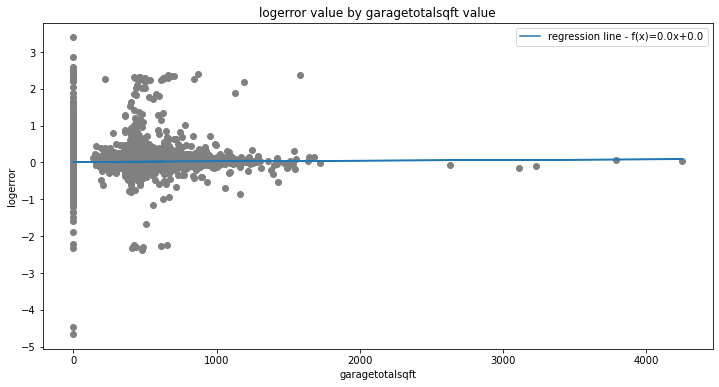

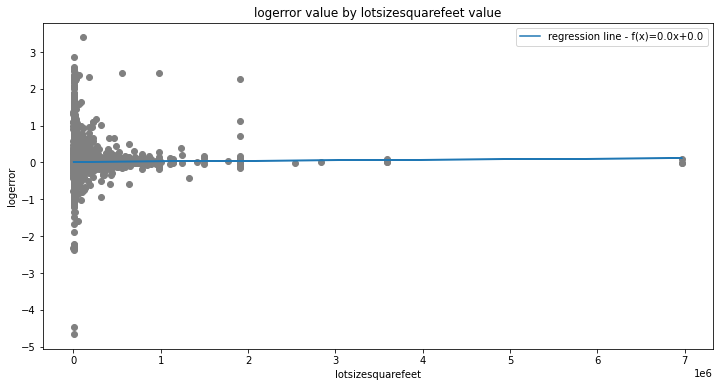

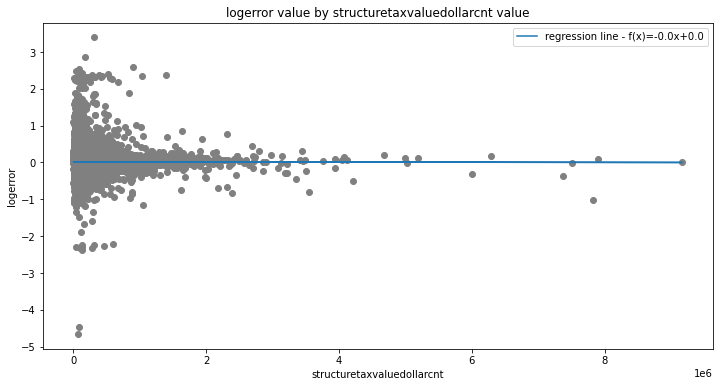

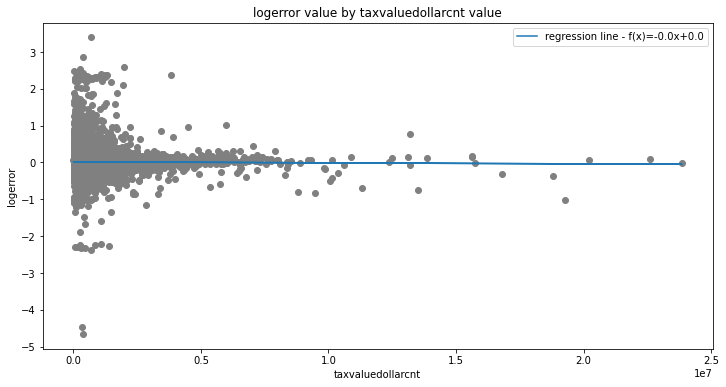

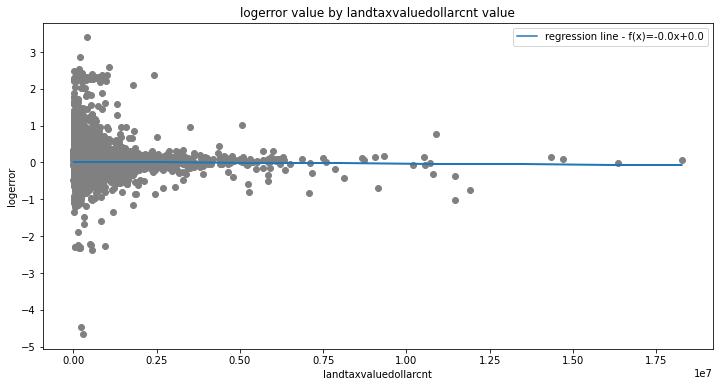

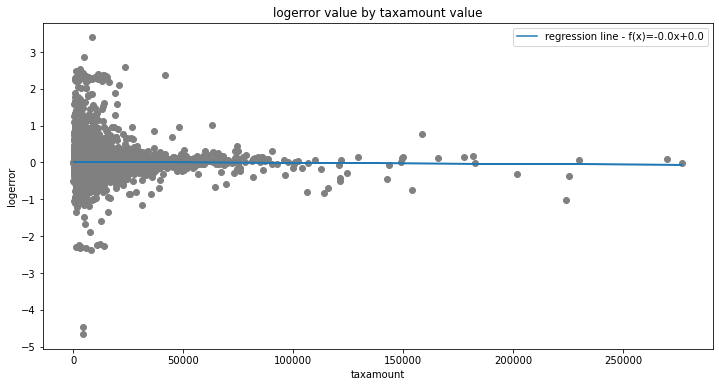

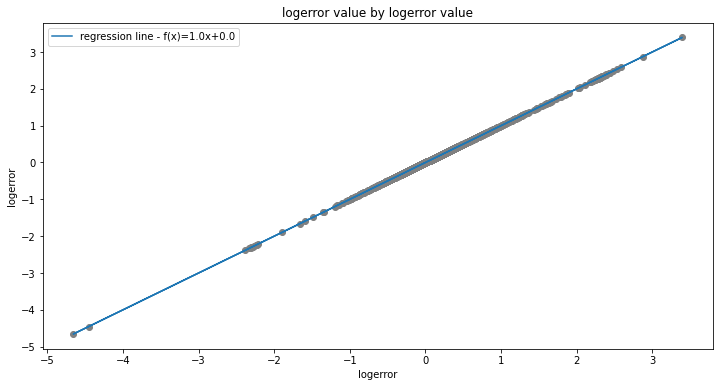

In [34]:
l=1

for col1 in continous_list:
            plt.figure(figsize=(12, 6))
            x=train[col1]
            y=train[target]
            plt.plot(x, y, "o",color="grey")
            m,b = np.polyfit(x,y,1)
            plt.plot(x,m*x+b,label=f"regression line - f(x)={round(m,0)}x+{round(b,0)}")
            plt.xlabel(col1)
            plt.ylabel(target)
            plt.legend()
            plt.title(f"{target} value by {col1} value")
            plt.show()

In [35]:
train

,id,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,latitude,...,logerror,airconditioningdesc,heatingorsystemdesc,propertylandusedesc,state,county,tract,block,logerror_bin,error
49188,686684,17129621,0.0,3.0,5.0,2440.0,Ventura Cnty,2.0,635.0,34222513.0,...,-0.018715,None,None,Single Family Residential,6,111,005303,2034,-1sig~1sig,0.957823
75645,960174,11967371,0.0,2.0,3.0,1649.0,Los Angeles Cnty,0.0,0.0,34114217.0,...,-0.174936,None,Central,Single Family Residential,6,037,183510,1005,<-1sig,0.668443
42857,2359338,11239045,0.0,2.0,2.0,853.0,Los Angeles Cnty,0.0,0.0,34556200.0,...,-0.061847,Central,Central,Condominium,6,037,910715,2004,-1sig~1sig,0.867267
35697,436130,11295899,0.0,2.0,3.0,1263.0,Los Angeles Cnty,0.0,0.0,34694650.0,...,0.027004,Central,Central,Single Family Residential,6,037,900609,2003,-1sig~1sig,1.064153
40323,429699,14248193,0.0,2.0,4.0,1738.0,Orange Cnty,2.0,420.0,33763088.0,...,-0.047005,None,None,Single Family Residential,6,059,075401,2011,-1sig~1sig,0.897419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63021,272244,11471889,0.0,3.0,4.0,2674.0,Los Angeles Cnty,0.0,0.0,33929588.0,...,0.011502,None,Central,Single Family Residential,6,037,620101,3004,-1sig~1sig,1.026837
28530,2038822,13891248,0.0,3.0,6.0,2865.0,Orange Cnty,2.0,420.0,33621230.0,...,0.138144,None,None,Single Family Residential,6,059,063400,3000,-1sig~1sig,1.374499
77460,1307160,12938228,0.0,2.0,3.0,1789.0,Los Angeles Cnty,0.0,0.0,34085354.0,...,-0.061685,None,Central,Single Family Residential,6,037,405301,2001,-1sig~1sig,0.867591
11839,34452,11682452,0.0,2.0,2.0,1152.0,Los Angeles Cnty,0.0,0.0,34042987.0,...,0.060462,Central,Central,Single Family Residential,6,037,800410,1046,-1sig~1sig,1.149376


In [36]:
train.basementsqft.describe()

count    41286.000000
mean         0.582813
std         27.271502
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3560.000000
Name: basementsqft, dtype: float64

In [37]:
train.basementsqft.unique()

array([   0.,  640.,  700.,  396.,  786.,  314.,  273.,  800.,  900.,
         90.,  912.,  252.,  352.,  394.,  384.,  588., 1252.,  254.,
        515., 1416.,  224., 3560.,  819.,  168.,  600.,  604.,  669.,
       1218.,  405.,  112.,  645.,   38., 1969.])

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=19.12487, p=0.00001

 We reject the null Hypothesis ( b̶a̶s̶e̶m̶e̶n̶t̶s̶q̶f̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶a̶s̶e̶m̶e̶n̶t̶s̶q̶f̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=2.00444, p=0.04521
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=18.97706, p=0.00001

 We fail to reject the null hypothesis ( basementsqft of logerror_bin>1sig has identical average values to basementsqft of other logerror_bin-1sig~1sig ) t=1.30475, p=0.19213
-----------------------------
we can accept that there are equal variance in these two groups with 0.87 certainty Flag=T stat=0.02796, p=0.86721

 We fail to reject the null hypothesis ( basementsqft of logerror_bin>1sig has identical average values to b

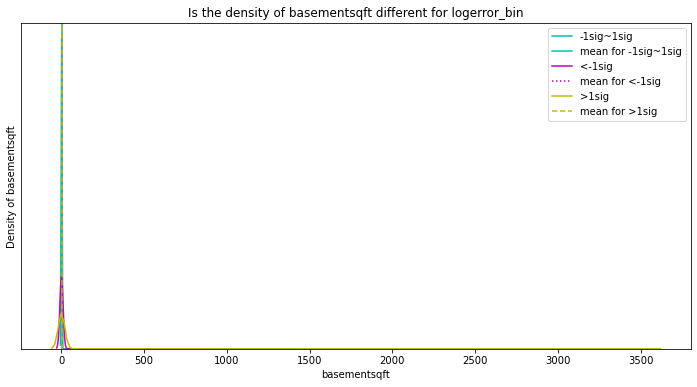

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=103.18562, p=0.00000

 We reject the null Hypothesis ( c̶a̶l̶c̶u̶l̶a̶t̶e̶d̶f̶i̶n̶i̶s̶h̶e̶d̶s̶q̶u̶a̶r̶e̶f̶e̶e̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶a̶l̶c̶u̶l̶a̶t̶e̶d̶f̶i̶n̶i̶s̶h̶e̶d̶s̶q̶u̶a̶r̶e̶f̶e̶e̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=4.33470, p=0.00002
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=87.47467, p=0.00000

 We reject the null Hypothesis ( c̶a̶l̶c̶u̶l̶a̶t̶e̶d̶f̶i̶n̶i̶s̶h̶e̶d̶s̶q̶u̶a̶r̶e̶f̶e̶e̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶>̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶a̶l̶c̶u̶l̶a̶t̶e̶d̶f̶i̶n̶i̶s̶h̶e̶d̶s̶q̶u̶a̶r̶e̶f̶e̶e̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=3.18527, p=0.00147
-----------------------

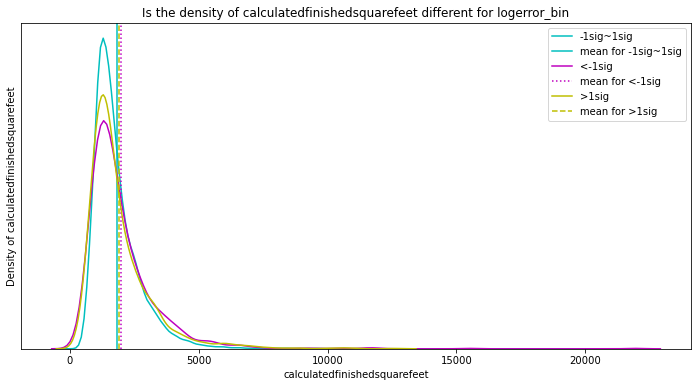

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=79.59090, p=0.00000

 We reject the null Hypothesis ( g̶a̶r̶a̶g̶e̶t̶o̶t̶a̶l̶s̶q̶f̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶g̶a̶r̶a̶g̶e̶t̶o̶t̶a̶l̶s̶q̶f̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=-10.21302, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=14.31784, p=0.00015

 We reject the null Hypothesis ( g̶a̶r̶a̶g̶e̶t̶o̶t̶a̶l̶s̶q̶f̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶>̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶g̶a̶r̶a̶g̶e̶t̶o̶t̶a̶l̶s̶q̶f̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=-3.89807, p=0.00010
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=

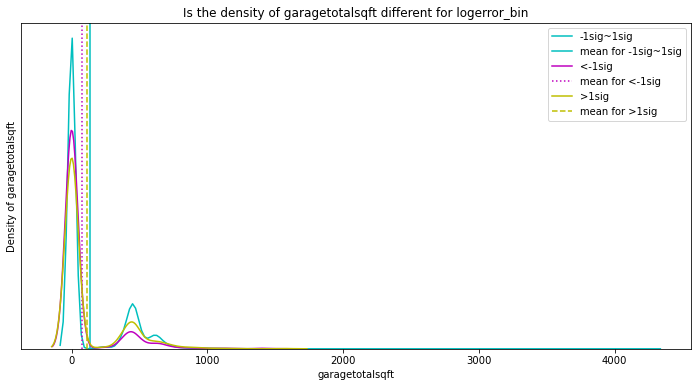

-----------------------------
we can accept that there are equal variance in these two groups with 0.06 certainty Flag=T stat=3.53177, p=0.06021

 We fail to reject the null hypothesis ( lotsizesquarefeet of logerror_bin<-1sig has identical average values to lotsizesquarefeet of other logerror_bin-1sig~1sig ) t=-1.84185, p=0.06550
-----------------------------
we can accept that there are equal variance in these two groups with 0.07 certainty Flag=T stat=3.30732, p=0.06898

 We fail to reject the null hypothesis ( lotsizesquarefeet of logerror_bin>1sig has identical average values to lotsizesquarefeet of other logerror_bin-1sig~1sig ) t=-1.80248, p=0.07148
-----------------------------
we can accept that there are equal variance in these two groups with 0.74 certainty Flag=T stat=0.10634, p=0.74437

 We fail to reject the null hypothesis ( lotsizesquarefeet of logerror_bin>1sig has identical average values to lotsizesquarefeet of other logerror_bin<-1sig ) t=0.30245, p=0.76233


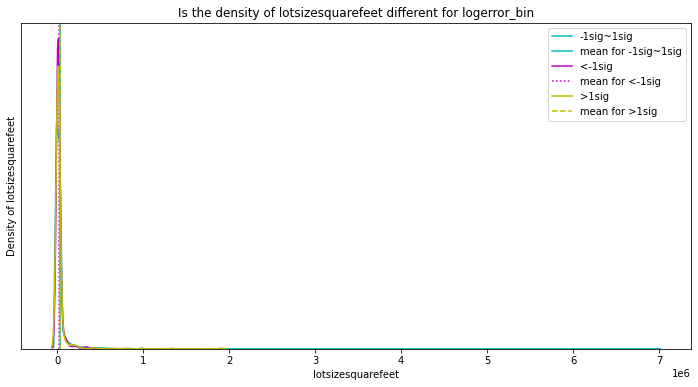

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=113.86678, p=0.00000

 We reject the null Hypothesis ( s̶t̶r̶u̶c̶t̶u̶r̶e̶t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶s̶t̶r̶u̶c̶t̶u̶r̶e̶t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=3.66675, p=0.00025
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=13.41931, p=0.00025

 We fail to reject the null hypothesis ( structuretaxvaluedollarcnt of logerror_bin>1sig has identical average values to structuretaxvaluedollarcnt of other logerror_bin-1sig~1sig ) t=-0.88772, p=0.37479
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=12.95152, p=0.00032

 We reject the null Hy

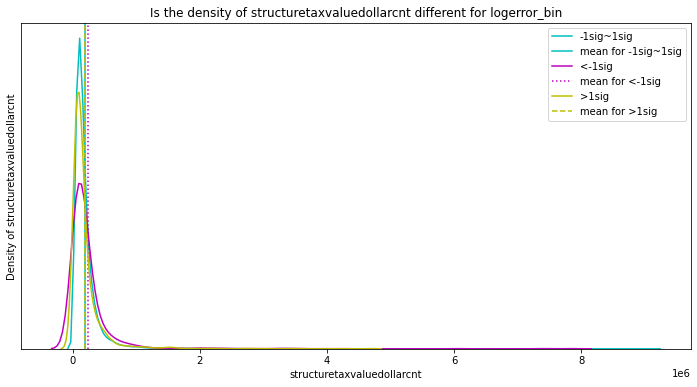

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=192.42365, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=5.37142, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=12.96856, p=0.00032

 We fail to reject the null hypothesis ( taxvaluedollarcnt of logerror_bin>1sig has identical average values to taxvaluedollarcnt of other logerror_bin-1sig~1sig ) t=-0.82599, p=0.40890
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=26.28908, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶l

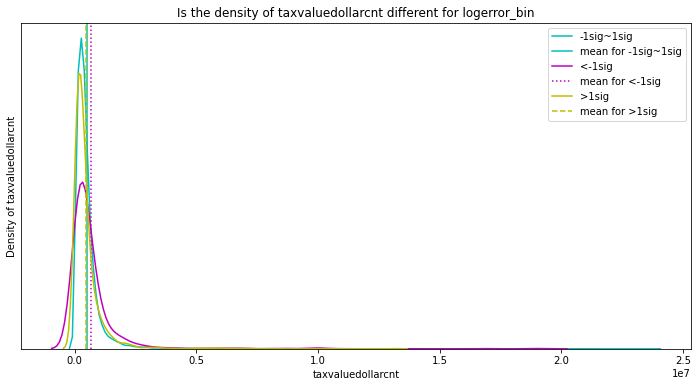

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=185.11129, p=0.00000

 We reject the null Hypothesis ( l̶a̶n̶d̶t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶a̶n̶d̶t̶a̶x̶v̶a̶l̶u̶e̶d̶o̶l̶l̶a̶r̶c̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=5.84362, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 0.97 certainty Flag=F stat=4.96420, p=0.02588

 We fail to reject the null hypothesis ( landtaxvaluedollarcnt of logerror_bin>1sig has identical average values to landtaxvaluedollarcnt of other logerror_bin-1sig~1sig ) t=-0.69672, p=0.48605
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=32.42725, p=0.00000

 We reject the null Hypothesis ( l̶a̶n̶d̶t̶a̶x̶v̶a̶l

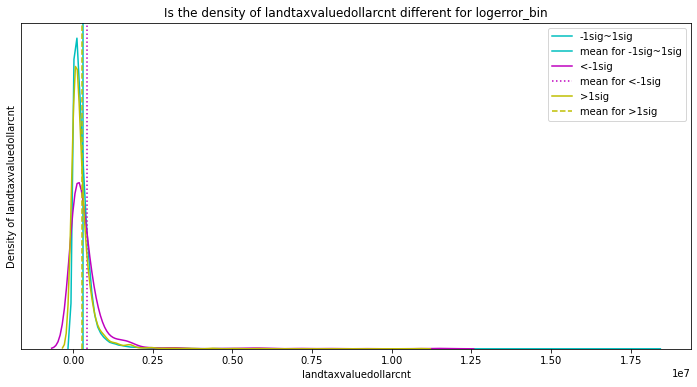

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=197.28893, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶a̶m̶o̶u̶n̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶a̶m̶o̶u̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=5.41501, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=12.11591, p=0.00050

 We fail to reject the null hypothesis ( taxamount of logerror_bin>1sig has identical average values to taxamount of other logerror_bin-1sig~1sig ) t=-0.95216, p=0.34112
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=26.99379, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶a̶m̶o̶u̶n̶t̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶>̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a

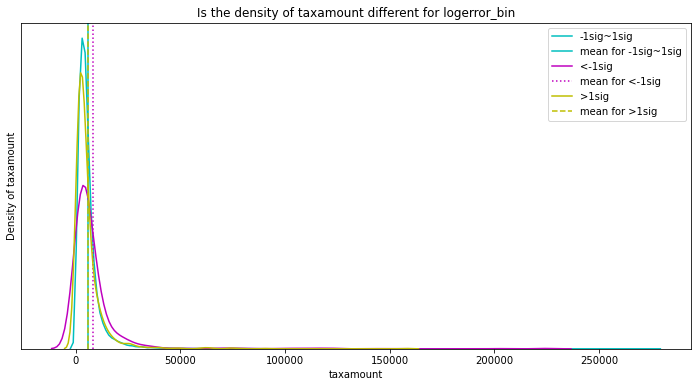

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=2789.65315, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶<̶-̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=-41.49600, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=6836.58806, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶>̶1̶s̶i̶g̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶_̶b̶i̶n̶-̶1̶s̶i̶g̶~̶1̶s̶i̶g̶ ) t=48.25402, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=50.16564, p=0.00000

 We reject the null Hypothesis 

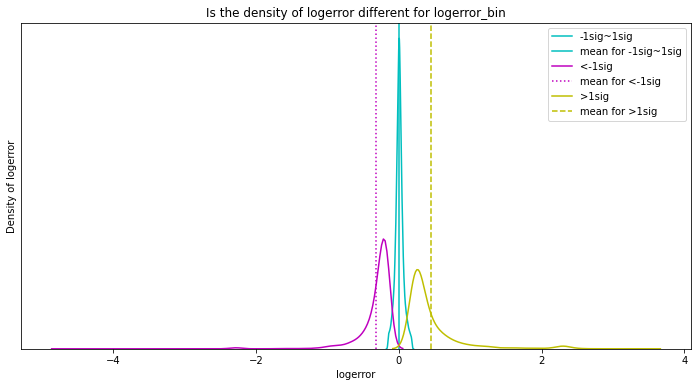

In [38]:
cat="logerror_bin"

for num in continous_list:

    alpha = .05

    for cat_1 in train[cat].unique():
        for cat_2 in train[cat].unique():
            if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
                H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
                Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
                print("-----------------------------")
                #compare variances to know how to run the test
                stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
                stat,pval
                if pval > 0.05:
                    equal_var_flag = True
                    print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
                else:
                    equal_var_flag = False
                    print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))


                t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )

                if p > alpha:
                    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
                else:
                    print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


    plt.figure(figsize=(12,6))
    plt.title(f"Is the density of {num} different for {cat}")


    plt.ylabel(f"Density of {num}")
    plt.yticks([],[])

    colorlist=['c', 'm', 'y', 'k']
    linestyle_list = ['solid', 'dotted','dashed','dashdot']

    for i in enumerate(train[cat].unique()):

        sns.kdeplot(train[train[cat] == i[1]][num],
                    label=f"{i[1]}",
                    color=colorlist[i[0]])
        plt.axvline(train[train[cat] == i[1]][num].mean(),
                    color=colorlist[i[0]],
                    ls=linestyle_list[i[0]],
                    label=f"mean for {i[1]}")

    plt.xlabel(f"{num}")
    plt.legend()
    plt.show()

(array([2.380e+02, 1.641e+03, 5.875e+03, 2.114e+03, 4.760e+02, 1.410e+02,
        7.200e+01, 3.000e+01, 1.100e+01, 1.100e+01, 8.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 136.        ,  273.16666667,  410.33333333,  547.5       ,
         684.66666667,  821.83333333,  959.        , 1096.16666667,
        1233.33333333, 1370.5       , 1507.66666667, 1644.83333333,
        1782.        , 1919.16666667, 2056.33333333, 2193.5       ,
        2330.66666667, 2467.83333333, 2605.        , 2742.16666667,
        2879.33333333, 3016.5       , 3153.66666667, 3290.83333333,
        3428.        , 3565.16666667, 3702.33333333, 3839.5       ,
        3976.66666667, 4113.83333333, 4251.        ]),
 <BarContainer object of 30 artists>)

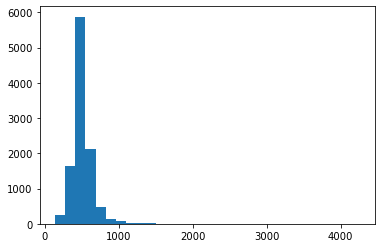

In [39]:
plt.hist(train[train.garagetotalsqft>0]["garagetotalsqft"],30)

In [40]:
train[train.garagetotalsqft>0]["garagetotalsqft"].value_counts()

400.0     496
360.0     408
462.0     395
441.0     392
460.0     350
         ... 
899.0       1
1230.0      1
362.0       1
835.0       1
1511.0      1
Name: garagetotalsqft, Length: 729, dtype: int64

In [41]:
discrete_list

['id',
 'fips',
 'parcelid',
 'garagecarcnt',
 'latitude',
 'bathroomcnt',
 'logerror_bin',
 'airconditioningdesc',
 'heatingorsystemdesc',
 'longitude',
 'rawcensustractandblock',
 'bedroomcnt',
 'regionidzip',
 'yearbuilt',
 'censustractandblock',
 'propertylandusedesc',
 'state',
 'county',
 'tract',
 'block']

In [42]:
train["decade"] = pd.cut(train.yearbuilt,[0,1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000,2010,2020])

In [43]:
temp_list = [ 'bathroomcnt','airconditioningdesc','heatingorsystemdesc','bedroomcnt','county','decade','propertylandusedesc']
for cat in temp_list:
    print(train[cat].nunique())

21
5
9
14
5
11
12


-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=11.84796, p=0.00058

 We fail to reject the null hypothesis ( logerror of bathroomcnt2.0 has identical average values to logerror of other bathroomcnt3.0 ) t=-1.15492, p=0.24813
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=144.11243, p=0.00000

 We fail to reject the null hypothesis ( logerror of bathroomcnt1.0 has identical average values to logerror of other bathroomcnt3.0 ) t=-0.23239, p=0.81624
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=108.23410, p=0.00000

 We fail to reject the null hypothesis ( logerror of bathroomcnt1.0 has identical average values to logerror of other bathroomcnt2.0 ) t=0.57916, p=0.56249
-----------------------------
we can reject that there are equal variance in these two gro

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


we can accept that there are equal variance in these two groups with 0.69 certainty Flag=T stat=0.15657, p=0.69249

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶8̶.̶5̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶3̶.̶5̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.47 certainty Flag=T stat=0.51922, p=0.47146

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶8̶.̶5̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶5̶.̶0̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.72 certainty Flag=T stat=0.13268, p=0.71585

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶8̶.̶5̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ 

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom



 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶1̶3̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶4̶.̶0̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.74 certainty Flag=T stat=0.10773, p=0.74277

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶1̶3̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶2̶.̶5̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.63 certainty Flag=T stat=0.22835, p=0.63324

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶1̶3̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶c̶n̶t̶0̶.̶0̶ ) t=nan, p=nan
--------

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


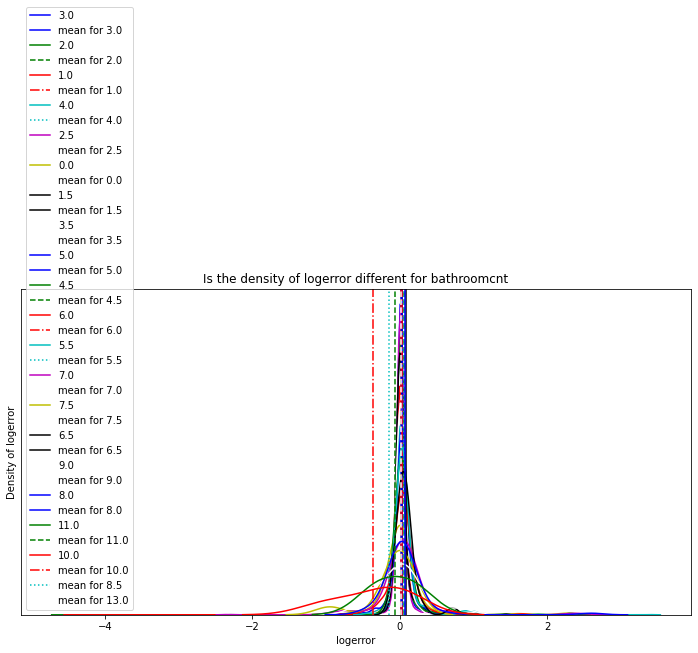

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=105.24859, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶a̶i̶r̶c̶o̶n̶d̶i̶t̶i̶o̶n̶i̶n̶g̶d̶e̶s̶c̶C̶e̶n̶t̶r̶a̶l̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶a̶i̶r̶c̶o̶n̶d̶i̶t̶i̶o̶n̶i̶n̶g̶d̶e̶s̶c̶N̶o̶n̶e̶ ) t=-2.67764, p=0.00742
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=15.17201, p=0.00010

 We fail to reject the null hypothesis ( logerror of airconditioningdescYes has identical average values to logerror of other airconditioningdescNone ) t=0.05763, p=0.95405
-----------------------------
we can accept that there are equal variance in these two groups with 0.25 certainty Flag=T stat=1.33277, p=0.24833

 We fail to reject the null hypothesis ( logerror of airconditioningdescYes has identical average values t

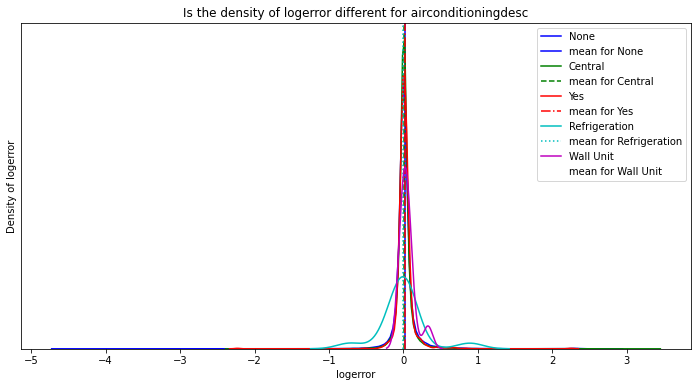

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=23.26066, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶C̶e̶n̶t̶r̶a̶l̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶N̶o̶n̶e̶ ) t=-4.79251, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=28.04392, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶F̶l̶o̶o̶r̶/̶W̶a̶l̶l̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶N̶o̶n̶e̶ ) t=-3.12395, p=0.00179
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=131.51604, p=

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom


we can accept that there are equal variance in these two groups with 0.63 certainty Flag=T stat=0.23301, p=0.62930

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶G̶r̶a̶v̶i̶t̶y̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶C̶e̶n̶t̶r̶a̶l̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.57 certainty Flag=T stat=0.32639, p=0.56781

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶G̶r̶a̶v̶i̶t̶y̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶F̶l̶o̶o̶r̶/̶W̶a̶l̶l̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.72 certainty Flag=T stat=0.13012, p=0.71855

 We reject the null Hypothes

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


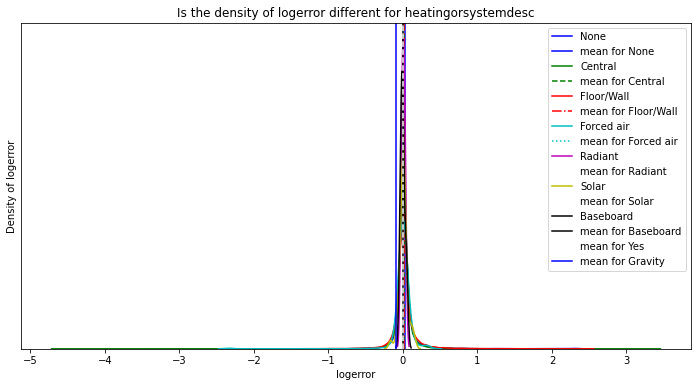

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=22.24958, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶e̶d̶r̶o̶o̶m̶c̶n̶t̶3̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶e̶d̶r̶o̶o̶m̶c̶n̶t̶5̶.̶0̶ ) t=-5.30268, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 0.96 certainty Flag=F stat=4.19417, p=0.04059

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶b̶e̶d̶r̶o̶o̶m̶c̶n̶t̶2̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶b̶e̶d̶r̶o̶o̶m̶c̶n̶t̶5̶.̶0̶ ) t=-5.70915, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=17.96148, p=0.00002

 We fail to reject the null hypothesis ( logerror of bedroomcnt2.0 has identical average v

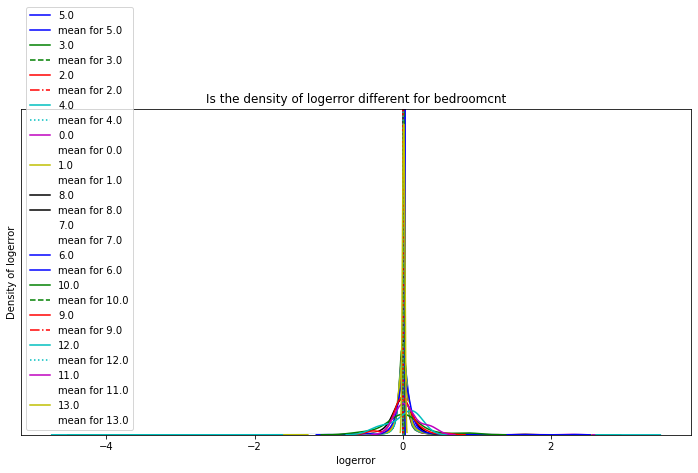

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=24.71272, p=0.00000

 We fail to reject the null hypothesis ( logerror of county037 has identical average values to logerror of other county111 ) t=0.10980, p=0.91258
-----------------------------
we can reject that there are equal variance in these two groups with 0.98 certainty Flag=F stat=5.58788, p=0.01810

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶c̶o̶u̶n̶t̶y̶0̶5̶9̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶c̶o̶u̶n̶t̶y̶1̶1̶1̶ ) t=3.13510, p=0.00172
-----------------------------
we can reject that there are equal variance in these two groups with 0.98 certainty Flag=F stat=5.65974, p=0.01736

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶c̶o̶u̶n̶t̶y̶0̶5̶9̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶c̶o̶u̶n̶t̶y̶0̶3̶7̶ )

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 We fail to reject the null hypothesis ( logerror of county065 has identical average values to logerror of other county037 ) t=1.88413, p=0.05956
-----------------------------
we can accept that there are equal variance in these two groups with 0.84 certainty Flag=T stat=0.04124, p=0.83907

 We fail to reject the null hypothesis ( logerror of county065 has identical average values to logerror of other county059 ) t=1.41436, p=0.15729
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=inf, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶c̶o̶u̶n̶t̶y̶0̶6̶5̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶c̶o̶u̶n̶t̶y̶8̶3̶0̶ ) t=nan, p=nan


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


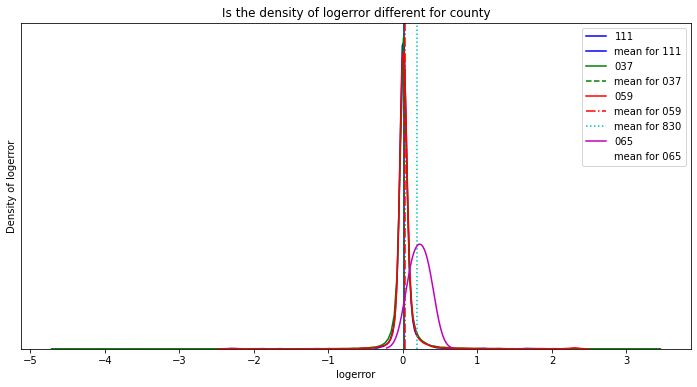

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=158.81191, p=0.00000

 We fail to reject the null hypothesis ( logerror of decade(0, 1920] has identical average values to logerror of other decade(1990, 2000] ) t=1.62121, p=0.10519
-----------------------------
we can accept that there are equal variance in these two groups with 0.96 certainty Flag=T stat=0.00244, p=0.96062

 We fail to reject the null hypothesis ( logerror of decade(1980, 1990] has identical average values to logerror of other decade(1990, 2000] ) t=-1.75638, p=0.07906
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=199.75690, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶d̶e̶c̶a̶d̶e̶(̶1̶9̶8̶0̶,̶ ̶1̶9̶9̶0̶]̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶d̶e̶c̶a̶d̶e̶(̶0̶,̶ ̶1̶9̶2̶0̶]̶ ) t=-2.5

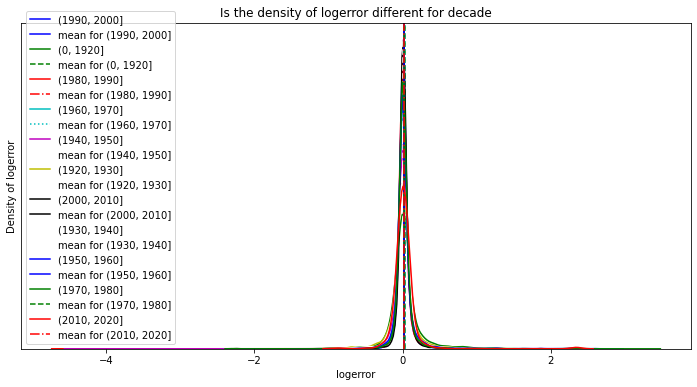

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=73.48484, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶p̶r̶o̶p̶e̶r̶t̶y̶l̶a̶n̶d̶u̶s̶e̶d̶e̶s̶c̶C̶o̶n̶d̶o̶m̶i̶n̶i̶u̶m̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶p̶r̶o̶p̶e̶r̶t̶y̶l̶a̶n̶d̶u̶s̶e̶d̶e̶s̶c̶S̶i̶n̶g̶l̶e̶ ̶F̶a̶m̶i̶l̶y̶ ̶R̶e̶s̶i̶d̶e̶n̶t̶i̶a̶l̶ ) t=-2.59275, p=0.00953
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=27.14519, p=0.00000

 We fail to reject the null hypothesis ( logerror of propertylandusedescTriplex (3 Units, Any Combination) has identical average values to logerror of other propertylandusedescSingle Family Residential ) t=-1.76647, p=0.07831
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=98.24695, p=0.00000

 We 

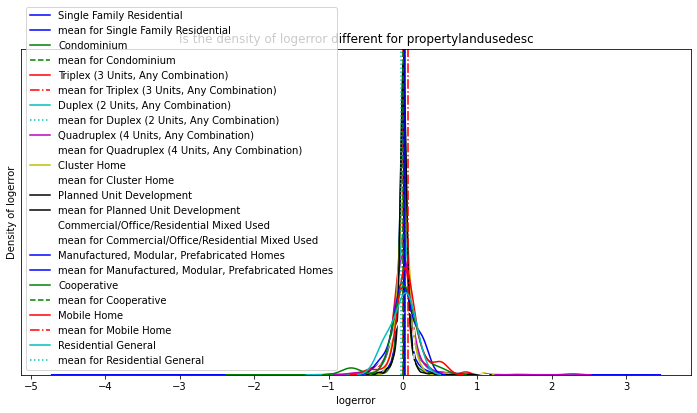

In [44]:
num="logerror"
for cat in temp_list:

    alpha = .05

    for cat_1 in train[cat].unique():
        for cat_2 in train[cat].unique():
            if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
                H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
                Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
                print("-----------------------------")
                #compare variances to know how to run the test
                stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
                stat,pval
                if pval > 0.05:
                    equal_var_flag = True
                    print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
                else:
                    equal_var_flag = False
                    print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))


                t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )

                if p > alpha:
                    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
                else:
                    print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


    plt.figure(figsize=(12,6))
    plt.title(f"Is the density of {num} different for {cat}")


    plt.ylabel(f"Density of {num}")
    plt.yticks([],[])

    colorlist=["b","g","r","c","m","y","k","w"]
    linestyle_list = ['-', '--', '-.', ':', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted']

    for i in enumerate(train[cat].unique()):

        sns.kdeplot(train[train[cat] == i[1]][num],
                    label=f"{i[1]}",
                    color=colorlist[i[0]%len(colorlist)])
        plt.axvline(train[train[cat] == i[1]][num].mean(),
                    color=colorlist[i[0]%len(colorlist)],
                    ls=linestyle_list[i[0]%len(colorlist)],
                    label=f"mean for {i[1]}")

    plt.xlabel(f"{num}")
    plt.legend()
    plt.show()

h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶N̶o̶n̶e̶, ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶F̶l̶o̶o̶r̶/̶W̶a̶l̶l̶, ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶F̶o̶r̶c̶e̶d̶ a̶i̶r̶


p̶r̶o̶p̶e̶r̶t̶y̶l̶a̶n̶d̶u̶s̶e̶d̶e̶s̶c̶C̶o̶n̶d̶o̶m̶i̶n̶i̶u̶m̶, p̶r̶o̶p̶e̶r̶t̶y̶l̶a̶n̶d̶u̶s̶e̶d̶e̶s̶c̶S̶i̶n̶g̶l̶e̶ ̶F̶a̶m̶i̶l̶y̶ ̶R̶e̶s̶i̶d̶e̶n̶t̶i̶a̶l̶


c̶o̶u̶n̶t̶y̶0̶5̶9̶, c̶o̶u̶n̶t̶y̶8̶3̶0̶, c̶o̶u̶n̶t̶y̶1̶1̶1̶



In [45]:
temp_list

['bathroomcnt',
 'airconditioningdesc',
 'heatingorsystemdesc',
 'bedroomcnt',
 'county',
 'decade',
 'propertylandusedesc']

In [46]:
train.columns.tolist()

['id',
 'parcelid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'garagecarcnt',
 'garagetotalsqft',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror',
 'airconditioningdesc',
 'heatingorsystemdesc',
 'propertylandusedesc',
 'state',
 'county',
 'tract',
 'block',
 'logerror_bin',
 'error',
 'decade']

In [47]:
train[['bathroomcnt','bedroomcnt','garagetotalsqft','regionidzip','logerror','heatingorsystemdesc','logerror_bin','decade']]

,bathroomcnt,bedroomcnt,garagetotalsqft,regionidzip,logerror,heatingorsystemdesc,logerror_bin,decade
49188,3.0,5.0,635.0,97091.0,-0.018715,None,-1sig~1sig,"(1990, 2000]"
75645,2.0,3.0,0.0,96023.0,-0.174936,Central,<-1sig,"(0, 1920]"
42857,2.0,2.0,0.0,97328.0,-0.061847,Central,-1sig~1sig,"(1980, 1990]"
35697,2.0,3.0,0.0,97318.0,0.027004,Central,-1sig~1sig,"(1980, 1990]"
40323,2.0,4.0,420.0,97006.0,-0.047005,None,-1sig~1sig,"(1960, 1970]"
...,...,...,...,...,...,...,...,...
63021,3.0,4.0,0.0,96103.0,0.011502,Central,-1sig~1sig,"(1970, 1980]"
28530,3.0,6.0,420.0,96981.0,0.138144,None,-1sig~1sig,"(1950, 1960]"
77460,2.0,3.0,0.0,96523.0,-0.061685,Central,-1sig~1sig,"(1950, 1960]"
11839,2.0,2.0,0.0,96116.0,0.060462,Central,-1sig~1sig,"(1990, 2000]"


-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=23.26066, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶C̶e̶n̶t̶r̶a̶l̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶N̶o̶n̶e̶ ) t=-4.79251, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=28.04392, p=0.00000

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶F̶l̶o̶o̶r̶/̶W̶a̶l̶l̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶N̶o̶n̶e̶ ) t=-3.12395, p=0.00179
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=131.51604, p=

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom



 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶Y̶e̶s̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶C̶e̶n̶t̶r̶a̶l̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.57 certainty Flag=T stat=0.32639, p=0.56781

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶Y̶e̶s̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶F̶l̶o̶o̶r̶/̶W̶a̶l̶l̶ ) t=nan, p=nan
-----------------------------
we can accept that there are equal variance in these two groups with 0.72 certainty Flag=T stat=0.13012, p=0.71855

 We reject the null Hypothesis ( l̶o̶g̶e̶r̶r̶o̶r̶ ̶o̶f̶ ̶h̶e̶a̶t̶i̶n̶g̶o̶r̶s̶y̶s̶t̶e̶m̶d̶e̶s̶c̶Y̶e̶s̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


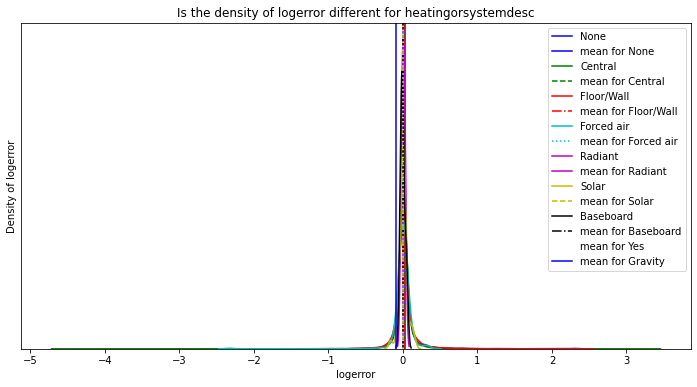

In [48]:
num="logerror"

cat = "heatingorsystemdesc"

alpha = .05

for cat_1 in train[cat].unique():
    for cat_2 in train[cat].unique():
        if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
            H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
            Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
            print("-----------------------------")
            #compare variances to know how to run the test
            stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
            stat,pval
            if pval > 0.05:
                equal_var_flag = True
                print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
            else:
                equal_var_flag = False
                print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))
            t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )
            if p > alpha:
                print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
            else:
                print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))
plt.figure(figsize=(12,6))
plt.title(f"Is the density of {num} different for {cat}")
plt.ylabel(f"Density of {num}")
plt.yticks([],[])
colorlist=["b","g","r","c","m","y","k","w"]
linestyle_list = ['-', '--', '-.', ':','solid', 'dashed', 'dashdot', 'dotted']
for i in enumerate(train[cat].unique()):
    sns.kdeplot(train[train[cat] == i[1]][num],
                label=f"{i[1]}",
                color=colorlist[i[0]%len(colorlist)])
    plt.axvline(train[train[cat] == i[1]][num].mean(),
                color=colorlist[i[0]%len(colorlist)],
                ls=linestyle_list[i[0]%len(colorlist)],
                label=f"mean for {i[1]}")
plt.xlabel(f"{num}")
plt.legend()
plt.show()


df = df[(df.propertylandusedesc == "Single Family Residential") | (df.propertylandusedesc == "Condominium")]
df = df[df.unitcnt < 2]

check_for_outliers = ['bathroomcnt', 'bedroomcnt', 
                        'calculatedfinishedsquarefeet','lotsizesquarefeet',
                        'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                        'landtaxvaluedollarcnt', 'taxamount']

outliers_df,outliers_list = wrangle_zillow.get_outliers(df[check_for_outliers], 1.5)
